In [1]:
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import datetime
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [55]:
pd.__version__

'0.20.3'

### Get Data Files

In [2]:
# Define NYC MTA turnstile data URL
url = 'http://web.mta.info/developers/turnstile.html'

In [3]:
# Send request and verify URL
rsp = requests.get(url)
print(rsp.url)

http://web.mta.info/developers/turnstile.html


In [4]:
# Parse HTML response
soup = BeautifulSoup(rsp.text, 'html.parser')

In [5]:
# Find all anchor tags with href attribute defined
a_tags = soup.find_all('a', href=True)

In [6]:
file_list = []
base_url = url.split('turnstile')[0]
for a in a_tags:
    tmp = re.search('data/nyct/turnstile/turnstile_\d*\.txt', a['href'])
    if tmp is not None:
        file_list.append(''.join([base_url, tmp.string]))        

In [7]:
# # Note: This only needs to be run once; comment out afterward.
# # Download txt files from NYC MTA website to local machine
# for file in file_list:
#     !wget -P ./turnstile_data/ {file}

### Compile Raw Data

In [8]:
# Note: This cell only needs to be run once; comment out afterward.
# Path to local directory with files; this needs to be set by the user.
data_path = '/home/cneiderer/Metis/turnstile_data' 
# Initialize empty dataframe
df = pd.DataFrame()
# Get list of data files
file_names = sorted(os.listdir(data_path))
for file in file_names:
    file_path = os.path.join(data_path, file)
    # Load data and concatenate with existing dataframe
    df = pd.concat([df, pd.read_csv(file_path)], axis=0)  
# Reset index for concatenated dataframe since each dataframe has own index, 
# which causes duplicate indices in concatenated dataframe  
df = df.reset_index(drop=True)   
# Save raw compiled dataframe as *.CSV and *.PKL for easy data retrieval
#df.to_csv('raw_turnstile_data.csv')
df.to_pickle('raw_turnstile_data.pkl')

### Data Munging / Preprocessing

#### Load Raw Data

In [9]:
# Load raw turnstile data
df = pickle.load(open('raw_turnstile_data.pkl', 'rb'))
# df = pickle.load(open('raw_turnstile_data_small.pkl', 'rb'))

# Remove whitespace from column names and make lowercase
df.columns = [x.strip().lower() for x in df.columns]

# Get rid of unnecessary columns
df = df.drop(['c/a', 'unit', 'scp', 'linename', 'division'], axis=1)

In [10]:
# Load HH200K data
df2 = pd.read_csv('HH200K.csv')

# Remove whitespace from column names and make lowercase
df2.columns = [x.strip().lower() for x in df2.columns]

In [11]:
# Load stations data
df3 = pd.read_csv('Stations.csv')

# Remove whitespace from column names and make lowercase
df3.columns = [x.strip().lower() for x in df3.columns]

#### Join Data

In [12]:
# Rename Stop Name to station so it can be used as the join key
df2 = df2.rename(index=str, columns={'stop name': 'station'})
df3 = df3.rename(index=str, columns={'stop name': 'station'})

In [13]:
# Set all station names to in the turnstile data and station data to lowercase so they can be joined
df.station = df.station.str.lower()
df2.station = df2.station.str.lower()
df3.station = df3.station.str.lower()

In [14]:
# Join turnstile data with station data via station column
df = df.join(df2.set_index('station'), on='station')

In [15]:
# Remove data that didn't have matching station key
df = df.dropna()

In [16]:
# Reset index for the joined dataframe
df = df.reset_index(drop=True)  

In [17]:
# Save joined dataset
df.to_pickle('joined_data.pkl')

#### Calculate Count Stats

In [56]:
# Load joined data
df = pickle.load(open('joined_data.pkl', 'rb'))

In [57]:
# Remove negative entries and negative exits
df = df[df.entries >= 0]
df = df[df.exits >= 0]

In [58]:
# Calculate count differences between audits for entries and exits; set any resulting nans to 0 
df[['entries_cnt', 'exits_cnt']] = df.groupby(['station'])[['entries', 'exits']].diff().fillna(0)

In [65]:
# Remove negative entries and negative exits
df = df[df.entries_cnt >= 0]
df = df[df.exits_cnt >= 0]

In [104]:
df2[df2.station == 'canal st']

,gtfs stop id,station,zip_code,gtfs latitude,gtfs longitude,perhh,bachdeg,graddeg,totgrad,2015 median household income
17,Q01,canal st,10013.0,40.718383,-74.000460,0.380334,0.448832,0.248187,0.697019,123445.0
18,R24,canal st,10007.0,40.713282,-74.006978,0.220690,0.448832,0.248187,0.697019,111939.0
103,M21,canal st,10007.0,40.713243,-74.003401,0.036534,0.102755,0.069843,0.172599,30900.0
167,A42,canal st,11201.0,40.688484,-73.985001,0.235472,0.359171,0.354828,0.713999,103533.0
323,228,canal st,10007.0,40.713051,-74.008811,0.616334,0.461141,0.435079,0.896220,200000.0
408,201,canal st,10470.0,40.903125,-73.850620,0.013616,0.126247,0.025597,0.151844,37786.0


#### Convert Date and Time to DateTime Objs
This allows dataframe to be subset by date and/or time

# Convert date and time strings to datetime objects
df['date_time'] = pd.to_datetime(df.date + df.time, format='%m/%d/%Y%H:%M:%S')

In [68]:
df['date_obj'] = pd.to_datetime(df.date, format='%m/%d/%Y')

In [101]:
df.head()

,station,date,time,desc,entries,exits,gtfs stop id,zip_code,gtfs latitude,gtfs longitude,perhh,bachdeg,graddeg,totgrad,2015 median household income,entries_cnt,exits_cnt,date_obj
0,canal st,01/31/2015,00:00:00,REGULAR,1360858.0,1620110.0,Q01,10013.0,40.718383,-74.000460,0.380334,0.448832,0.248187,0.697019,123445.0,0.0,0.0,2015-01-31
1,canal st,01/31/2015,00:00:00,REGULAR,1360858.0,1620110.0,R24,10007.0,40.713282,-74.006978,0.220690,0.448832,0.248187,0.697019,111939.0,0.0,0.0,2015-01-31
2,canal st,01/31/2015,00:00:00,REGULAR,1360858.0,1620110.0,M21,10007.0,40.713243,-74.003401,0.036534,0.102755,0.069843,0.172599,30900.0,0.0,0.0,2015-01-31
3,canal st,01/31/2015,00:00:00,REGULAR,1360858.0,1620110.0,A42,11201.0,40.688484,-73.985001,0.235472,0.359171,0.354828,0.713999,103533.0,0.0,0.0,2015-01-31
4,canal st,01/31/2015,00:00:00,REGULAR,1360858.0,1620110.0,228,10007.0,40.713051,-74.008811,0.616334,0.461141,0.435079,0.896220,200000.0,0.0,0.0,2015-01-31


In [107]:
mean_bach = df.groupby(['station'])[['bachdeg']].mean()
mean_bach

,bachdeg
station,
1 av,0.337547
103 st,0.381117
104 st,0.124550
110 st,0.450770
111 st,0.201818
116 st,0.242282
121 st,0.191774
125 st,0.321084
135 st,0.260484


In [112]:
bach_sort = mean_bach.sort_values(['bachdeg'], ascending=False)
bach_sort

,bachdeg
station,
central av,0.526942
57 st,0.508900
6 av,0.476905
franklin st,0.471326
18 st,0.461141
spring st,0.451269
110 st,0.450770
whitehall st,0.449442
astor pl,0.448167


In [114]:
bach_top = bach_sort.head(10)

In [124]:
bach_top = bach_top.reindex(index=bach_top.index[::-1])

In [120]:
bach_top['station'] = bach_top.index

In [125]:
bach_top

,bachdeg,station
station,,
33 st,0.447450,33 st
astor pl,0.448167,astor pl
whitehall st,0.449442,whitehall st
110 st,0.450770,110 st
spring st,0.451269,spring st
18 st,0.461141,18 st
franklin st,0.471326,franklin st
6 av,0.476905,6 av
57 st,0.508900,57 st


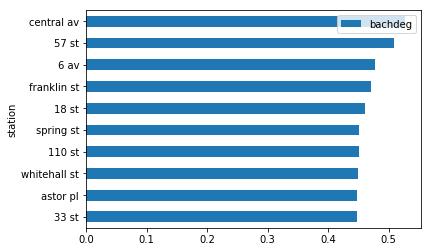

In [126]:
bach_top.plot(x='station', y='bachdeg', kind='barh')

In [70]:
df_tmp = df.groupby(['station', 'date_obj'])[['entries_cnt', 'exits_cnt']].sum()

In [77]:
df_test = df_tmp[df_tmp.entries_cnt < 4e4]

In [79]:
df_test.groupby(['station']).max()

,entries_cnt,exits_cnt
station,,
1 av,26444.0,27271.0
103 st,37515.0,26177.0
104 st,5350.0,2156.0
110 st,16278.0,12882.0
111 st,18846.0,11209.0
116 st,39710.0,8399075.0
121 st,2774.0,2088.0
125 st,39663.0,35191.0
135 st,23494.0,10718.0


In [81]:
df_mean = df_test.groupby(['station']).mean()

In [84]:
df_mean_sort = df_mean.sort_values('entries_cnt', ascending=False)

In [97]:
df_top = df_mean_sort.head(10)

In [98]:
df_top = df_top.reindex(index=df_top.index[::-1])

In [99]:
df_top['station'] = df_top.index
df_top

,entries_cnt,exits_cnt,station
station,,,
14 st,30694.906977,25306.046512,14 st
59 st,31606.125000,24127.111111,59 st
116 st,32134.444149,38992.079787,116 st
145 st,32960.046332,27049.992278,145 st
church av,33237.285047,23670.275701,church av
8 av,34072.041667,23512.307292,8 av
96 st,34751.722222,29880.981481,96 st
86 st,35047.230769,31302.076923,86 st
125 st,35574.000000,30404.241379,125 st


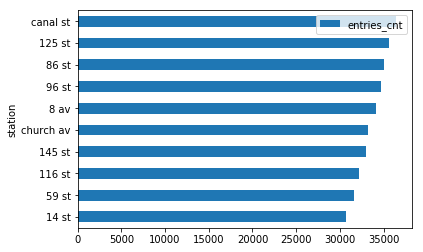

In [100]:
df_top.plot(x='station', y='entries_cnt', kind='barh')

### Sandbox Below

In [44]:
# df[(df['date'] > '2013-01-01') & (df['date'] < '2013-02-01')]
df_tmp2 = df[df['date_time'] >= '2017-01-01'] # & df['date_time'] <= '2015-06-15']

In [46]:
len(df_tmp2)

4925768

In [36]:
df_tmp = df.groupby(['station', 'date'])[['entries_cnt', 'exits_cnt']].sum()

In [37]:
df_tmp.head()

entries_cnt  exits_cnt
station date                              
1 av    01/28/2017    -202135.0  -138760.0
        01/29/2017      11918.0    10702.0
        01/30/2016    -700405.0  -203386.0
        01/30/2017      20926.0    22617.0
        01/31/2016      17393.0    18294.0

In [16]:
df['date_obj'] = pd.to_datetime(df.date, format='%m/%d/%Y')
df['time_obj'] = pd.to_datetime(df.time, format='%H:%M:%S')

In [17]:
df2 = df.head(20)

In [18]:
df2[datetime.datetime(1900, 1, 1, 8, 0, 0, 0) == df2.time_obj]

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,entries_diff,exits_diff,date_time,date_obj,time_obj
2,A002,R051,02-00-00,59 ST,NQR456,BMT,04/02/2016,08:00:00,REGULAR,5600877,1896313,14.0,20.0,2016-04-02 08:00:00,2016-04-02,1900-01-01 08:00:00
8,A002,R051,02-00-00,59 ST,NQR456,BMT,04/03/2016,08:00:00,REGULAR,5601643,1896578,5.0,12.0,2016-04-03 08:00:00,2016-04-03,1900-01-01 08:00:00
14,A002,R051,02-00-00,59 ST,NQR456,BMT,04/04/2016,08:00:00,REGULAR,5602297,1896893,41.0,100.0,2016-04-04 08:00:00,2016-04-04,1900-01-01 08:00:00


In [19]:
df2.time_obj.diff().fillna(0)

0             00:00:00
1             04:00:00
2             04:00:00
3             04:00:00
4             04:00:00
5             04:00:00
6    -1 days +04:00:00
7             04:00:00
8             04:00:00
9             04:00:00
10            04:00:00
11            04:00:00
12   -1 days +04:00:00
13            04:00:00
14            04:00:00
15            00:35:08
16            03:24:52
17            04:00:00
18            04:00:00
19   -1 days +08:00:00
Name: time_obj, dtype: timedelta64[ns]

In [20]:
df2.date_time.diff().fillna(0)

0    00:00:00
1    04:00:00
2    04:00:00
3    04:00:00
4    04:00:00
5    04:00:00
6    04:00:00
7    04:00:00
8    04:00:00
9    04:00:00
10   04:00:00
11   04:00:00
12   04:00:00
13   04:00:00
14   04:00:00
15   00:35:08
16   03:24:52
17   04:00:00
18   04:00:00
19   08:00:00
Name: date_time, dtype: timedelta64[ns]

In [24]:
t2 = df2.time[1:].reset_index(drop=True)

In [25]:
t1 = df2.time[0:-1].reset_index(drop=True)

In [26]:
pd.concat([t1.rename('t1'), t2.rename('t2')], axis=1)

,t1,t2
0,00:00:00,04:00:00
1,04:00:00,08:00:00
2,08:00:00,12:00:00
3,12:00:00,16:00:00
4,16:00:00,20:00:00
5,20:00:00,00:00:00
6,00:00:00,04:00:00
7,04:00:00,08:00:00
8,08:00:00,12:00:00
9,12:00:00,16:00:00


nan